# Clustering Longitudinal Time Series with Conditional Neural Process 

## Setup pytorch and numpy

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.distributions import Normal

In [2]:
torch.__version__

'1.13.1'

## Define this conditional neural process modules

There are two submodules "encoder" and "decoder" defined in the following cell.
The conditional neural process (CNP) module uses the encoder module that takes an input "context" tensor and encond the "context" into latent variables.  Combined with the latent variable and the a "target_x" value, the decode can predict the mean (mu) and deviation (sigma) of the targeted y value.  The parameters from the full connected layers are optimized by maximmu the log-likely of the observed y value according to the predicted mean and deviation.

In [3]:
class CNP_encoder(nn.Module):
    def __init__(self, layers=(2, 128, 128, 128 ,128)):
        """
        The keyword argument `layers` allows to speficy the number of nodes and 
        the number of layers for the full connected layers. The first 
        dimension should be (input_dim_size + 1)
        """
        super(CNP_encoder, self).__init__()
        
        modules = []
        for i in range(0, len(layers)-2):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.ReLU())
        
        modules.append(nn.Linear(layers[-2], layers[-1]))
        self.layers = nn.Sequential(*modules)
        
    def forward(self, context, context_mask):
        """
        context: tensor for the context of shape (batch_size, max_seq, input_dim_size+1)
        context_mask: tensor for masking unequal sequences of shape (batch_size, max_seq)
        """        

        h = self.layers(context)
        n = torch.stack( [torch.sum(context_mask, 1)] * h.shape[-1], dim =1)
        batch_size, seq_size = context_mask.shape
        x_mask= torch.stack([context_mask]* h.shape[-1] ,dim=2)
        h = torch.sum(h,1) / n.float()
        return h
    
class CNP_decoder(nn.Module):
    def __init__(self, layers=(128, 128, 128, 128)):
        """
        The keyword argument `layers` allows to speficy the number of nodes and 
        the number of layers for the full connected layers.
        """
        super(CNP_decoder, self).__init__()
        
        modules = [nn.Linear(layers[0]+1, layers[1])]
        modules.append(nn.ReLU())
        
        for i in range(1, len(layers)-1):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.ReLU())
        
        modules.append(nn.Linear(layers[-1], 2))
        self.layers = nn.Sequential(*modules)
        
    def forward(self, latent_target):
        """
        latent_target: 
        tensor for the latent + target input of shape (batch_size, latent_size+input_dim_size)
        """        
        h = self.layers(latent_target)
        mu = h[:,:,0]
        log_sigma = h[:,:,1]
        sigma = 0.1 + 0.9 * nn.functional.softplus(log_sigma)
        return mu, sigma

    
class CNP(nn.Module):
    def __init__(self, encoder_layers=(2, 128, 128, 128 ,128),
                       decoder_layers=(128, 128, 128, 128)):
        super(CNP, self).__init__()
        self.encoder = CNP_encoder(layers=encoder_layers)
        self.decoder = CNP_decoder(layers=decoder_layers)
        
    def init_weights(self):
        def init_weights_(m):
            if type(m) == nn.Linear:
                nn.init.xavier_uniform_(m.weight)
        self.apply(init_weights_)
    
    def forward(self, context, context_mask, target_x):
        h = self.encoder.forward(context, context_mask)
        h=torch.stack( [h]*target_x.shape[1], dim=1)
        h=torch.cat( (h, target_x), dim=2) 
        self.mu, self.sigma = self.decoder.forward(h)
        return self.mu, self.sigma
    

    def get_latent(self, context, context_mask):
        h = self.encoder.forward(context, context_mask)
        return h
    
    def loss(self, target_y, target_mask):
        s = target_y.shape
        target_y = target_y.reshape( (s[0], s[1]) )   
        mvn = Normal(self.mu, self.sigma)
        loss = -torch.sum(mvn.log_prob(target_y) * target_mask.float())
        return loss
    

Define an useful utility function helping us to prepare data to feed into the CNP network

In [4]:
def get_context_target_tensor(data, repeat = 1, sampling_rate = 0.5, min_size = 4, cuda=True): 
    """
        with input data = list of (x_i, y_i), 
            x_i: numpy array of float
            y_i: numpy array of float
        
        output torch tensor for context from x, y with `simpling_rate`
        
        the whole arry will be repeated sample with `repeat` times
        
        the output are list of tensors: context_t, context_mask_t, target_x_t, target_y_t, target_mask_t
            
            context_t, context_mask_t: context tensors 
                
                context_t.shape = (batch_dim_size, max_seq_len, 2)
                context_mask_t.shape = (batch_dim_size, max_seq_len)
                batch_dim_size = len(x) * repeat
                max_seq_len = max seq length in the context array
                
            target_x_t, target_y_t, target_mask_t: target tensors
             
                target_x_t.shape = (batch_dim_size, max_seq_len, 1)
                target_y_t.shape = (batch_dim_size, max_seq_len, 1)
                target_mask_t.shape = (batch_dim_size, max_seq_len)
                batch_dim_size = len(x) * repeat
                max_seq_len = max seq length in the target array
    """
    
    context = []
    context_mask = []
    target_x = []
    target_y = []
    target_mask = []
    
    for _ in range(repeat):
        for x, y in data:
            assert len(x) == len(y)
            if len(x) < min_size:
                continue

            assert sampling_rate <= 1
            if sampling_rate < 1:
                sample_size = math.ceil(len(x) * sampling_rate)      
                idx = random.sample(range(len(x)), sample_size)
                context_x = x[idx]
                context_y = y[idx]
            else:
                context_x = x
                context_y = y

            context.append(torch.tensor(np.array(list(zip(context_x, context_y))), dtype=torch.float))
            context_mask.append(torch.ones(len(context_x), dtype=torch.long))

            target_x.append(torch.tensor(np.array([x]).T, dtype=torch.float))
            target_y.append(torch.tensor(np.array([y]).T, dtype=torch.float))

            target_mask.append(torch.ones(len(x), dtype=torch.long))
    
    context_t = torch.nn.utils.rnn.pad_sequence(context, batch_first=True, padding_value=0)
    context_mask_t = torch.nn.utils.rnn.pad_sequence(context_mask, batch_first=True, padding_value=0)
    target_x_t = torch.nn.utils.rnn.pad_sequence(target_x, batch_first=True, padding_value=0)
    target_y_t = torch.nn.utils.rnn.pad_sequence(target_y, batch_first=True, padding_value=0)
    target_mask_t = torch.nn.utils.rnn.pad_sequence(target_mask, batch_first=True, padding_value=0)
    
    if cuda:
        context_t = context_t.cuda()
        context_mask_t = context_mask_t.cuda()
        target_x_t = target_x_t.cuda()
        target_y_t = target_y_t.cuda()
        target_mask_t = target_mask_t.cuda()
        
    return context_t, context_mask_t, target_x_t, target_y_t, target_mask_t 

loading matplotlib for plotting

In [5]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

## Generate a Testing Data Set

Here we generate a test data set that contains three set of qudratic curves. Each time curse belongs one of three groups curves which have differen fix effect within their own group. Upon the fix effects, each curve has it own mean curve deviated from the fix effect sepecific by random effect distributions. Then, a random noise are added to the mean curve.

One can vary the parameters to challege the netwrok. If the noises are too big, it will be diffcult to seperate the clusters.

In [6]:
from scipy import stats
from scipy.stats import norm
np.random.seed(222)
random.seed(222)

In [7]:
## define probablity distribution for fix and random effects.
fix_effect0 = stats.norm(15, 8)
fix_effect1 = stats.norm(-1.5, 2.5)
fix_effect2 = stats.norm(-0.02, .01)

rnd_effect0 = stats.norm(0, 1)
rnd_effect1 = stats.norm(0, 0.05)
rnd_effect2 = stats.norm(0, 0.01)

error_norm = stats.norm(0, 2.5)

In [8]:

n_subjects = [200, 200, 200]
total_subjects = sum(n_subjects)

fix = [(23.88728130421938, 0.10935632262701711, -0.024313316390816846), 
       (25.194112219215699, -1.2373171876908433, -0.027355924183603438), 
       (19.802521264749213, -0.2724731646210033, -0.030397060874138362)]

# for random fix effect
# fix = []
# for g in range(len(n_subjects)):
#    fix.append( (fix_effect0.rvs(1)[0], fix_effect1.rvs(1)[0], fix_effect2.rvs(1)[0]) )

data_train = []
groups = []
subject = []
time = []
measurement = []
g = 0
id_ = 0

for n_subject in n_subjects:
    for i in range(n_subject):
        obs = random.randint(10,15)
        t = 0
        rnd0 = rnd_effect0.rvs(1)[0]
        rnd1 = rnd_effect1.rvs(1)[0]
        rnd2 = rnd_effect2.rvs(1)[0]
        m_list = []
        t_list = []
        for n in range(obs):
            m = fix[g][0] + t * fix[g][1] + t*t * fix[g][2]
            m += rnd0 + t * rnd1 + t*t * rnd2
            m += error_norm.rvs(1)[0] 
            if m > 0:
                subject.append(id_)
                time.append(t)
                measurement.append(m)
                m_list.append(m)
                t_list.append(t)
            t += random.uniform(0.25, 2)
        
        data_train.append( (np.array(t_list), np.array(m_list)) )
        groups.append(g)
        id_ += 1
    g += 1


## Plot all generated curves together

Left: Without coloring the curve by the group, we might guess there are two, and perhaps three, different groups of curves. The group corresponds to the red group on the right plot is clear but the blue and yellow are more tangled.

Right: The curves are colored according to their groups. 

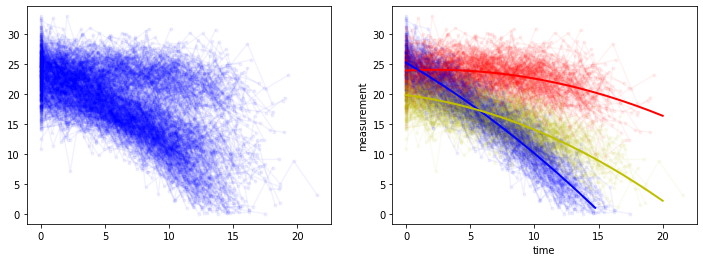

In [9]:
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
index = range(len(data_train))
for i in index:
    g = groups[i]
    xx = data_train[i][0]
    yy = data_train[i][1]
    plt.plot(xx,yy, '.-b', alpha=0.05)

plt.subplot(1,2,2)
index = list(range(len(data_train)))
random.shuffle(index)
cmap = {0:"r", 1:"b", 2:"y"}
for i in index:
    g = groups[i]
    xx = data_train[i][0]
    yy = data_train[i][1]
    plt.plot(xx,yy, '.-', color=cmap[g], alpha=0.05)
        
for g in range(len(n_subjects)):
    xx = np.linspace(0, 20, 20)
    yy = fix[g][0] + xx * fix[g][1] + xx * xx * fix[g][2]
    plt.plot(xx[yy>0], yy[yy>0], '-', color=cmap[g], lw=2, alpha=1)
    
plt.xlabel("time")
plt.ylabel("measurement")
plt.xlabel("time")
plt.ylabel("measurement");

## define CNP and train the network

In [10]:
cnp = CNP().cuda()
cnp.init_weights()
optimizer = torch.optim.Adam(cnp.parameters(), lr=0.001, weight_decay=10)

In [11]:
(context_t, 
 context_mask_t, 
 target_x_t, 
 target_y_t, 
 target_mask_t) = get_context_target_tensor(data_train, sampling_rate=0.5, repeat=100)


In [12]:
from tqdm import tqdm

In [13]:
loss_list = []
batch_size = 500
for i in tqdm(range(40)):
    
    for j in range(int(len(context_t)/batch_size)):
        s = random.randint(0, len(context_t)-batch_size)
        cnp(context_t[s:s+batch_size], 
            context_mask_t[s:s+batch_size], 
            target_x_t[s:s+batch_size])
        loss = cnp.loss(target_y_t[s:s+batch_size], 
                        target_mask_t[s:s+batch_size])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if i % 2 == 0:
        cnp(context_t, context_mask_t, target_x_t)
        loss = cnp.loss(target_y_t, target_mask_t)
        # print("epoch", i, loss.item())
        loss_list.append( (i, loss.item()) )

  0%|          | 0/40 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 440.00 MiB (GPU 0; 3.95 GiB total capacity; 2.03 GiB already allocated; 108.06 MiB free; 2.08 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

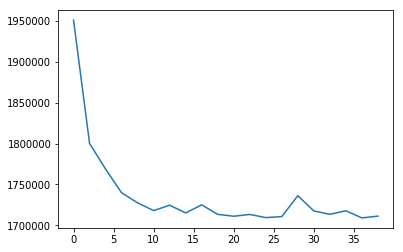

In [ ]:
xx, yy = list(zip(*loss_list))
plt.plot(xx, yy)


## Generate the "mean" curves with the trained model

In [ ]:

(context_t, 
 context_mask_t, 
 target_x_t, 
 target_y_t, 
 target_mask_t) = get_context_target_tensor(data_train, sampling_rate=1, repeat=1)

target_x = []
for i in range(600):
    target_x.append(torch.tensor(np.array([np.linspace(0,20,10)]).T, dtype=torch.float))
target_x_t = torch.nn.utils.rnn.pad_sequence(target_x, batch_first=True, padding_value=0).cuda()

mu, sigma = cnp(context_t, 
            context_mask_t, 
            target_x_t)




Let see how the mean curves look like

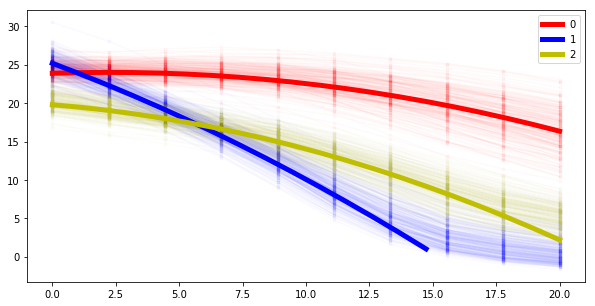

In [ ]:
plt.figure(figsize=(10,5))

for i in range(total_subjects):   
    len_ = target_x_t.shape[0]
    plt.plot(target_x_t[i].detach().cpu().numpy().flatten(),
             mu[i].detach().cpu().numpy()[:len_], 
             '.-', 
             color=cmap[groups[i]], 
             alpha=0.02)

for g in range(len(n_subjects)):
    xx = np.linspace(0, 20, 20)
    yy = fix[g][0] + xx * fix[g][1] + xx * xx * fix[g][2]
    plt.plot(xx[yy>0], yy[yy>0], '-', label="{}".format(g), color=cmap[g], lw=5, alpha=1)
     
plt.legend()

In [ ]:
latent = []
for i in range(0, total_subjects, 10):
    l_ = cnp.get_latent(context_t[i:i+10], context_mask_t[i:i+10])
    latent.extend(l_.detach().cpu().numpy())
latent=np.stack(latent)


Let's try to clustering the data. We can cluster on the inferred mean curves or the latent variables with a couple of standard clustering tools.  Using the default parameteres to generate the three groups curves, we should see three distinct clusters with t-SNE embedding. However, if there are bigger noises, then the speration will not be as clean as this current example. 

In [ ]:
from sklearn.manifold import TSNE

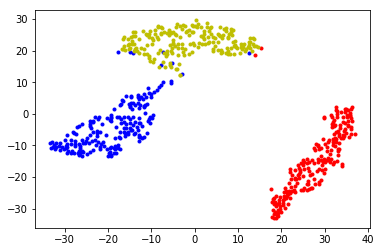

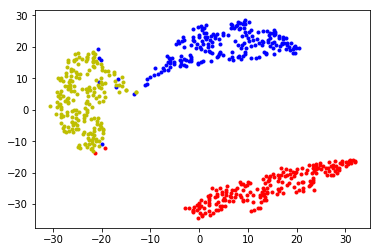

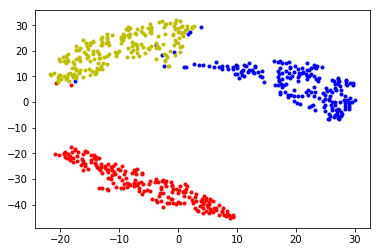

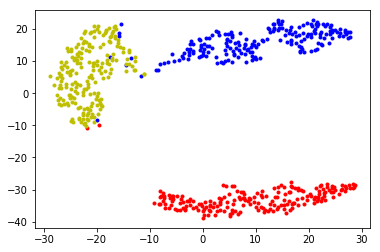

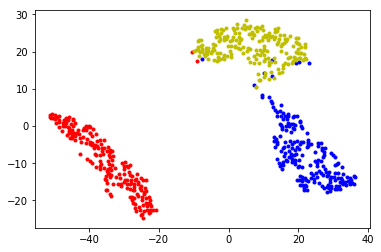

In [ ]:
mu_ = mu.detach().cpu().numpy()
groups = np.array(groups)
for i in range(5):
    X_embedded = TSNE(n_components=2).fit_transform(mu_)
    #X_embedded = TSNE(n_components=2).fit_transform(latent)
    plt.figure()
    for g in range(3):
        plt.plot(X_embedded[groups==g, 0], 
                 X_embedded[groups==g, 1], '.', color=cmap[g])


Let's test how well we can seperate the curves by simply applying k-mean or hierachical clustering using the smoothed curve (or the latent space vector). 

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
km = KMeans(init='k-means++', n_clusters=3, n_init=3).fit(mu_)
labels =km.labels_

In [ ]:
# ac = AgglomerativeClustering(n_clusters=3, linkage="ward").fit(mu_)
# labels =ac.labels_

In [ ]:
from collections import Counter

We should see three clearly seperated groups with some small mis-classification below.

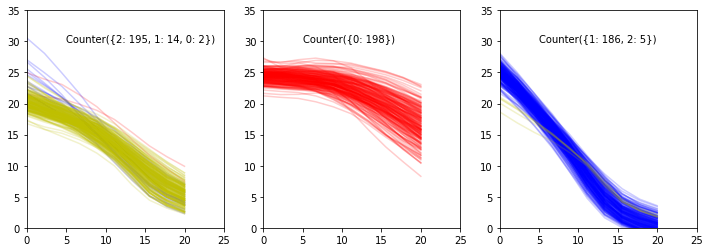

In [ ]:

mu_ = mu.detach().cpu().numpy()
plt.figure(figsize=(12,4))

for g in range(3):
    ids = np.array(list(range(0,len(data_train))))
    ids = ids[labels==g]
    plt.subplot(1, 3, g+1)
    c = 0
    for i in ids:
        if labels[i] != g:
            continue
        x = target_x_t[i].detach().cpu().numpy().flatten()
        plt.plot(x, mu_[i][:len(x)], alpha=0.2, color=cmap[groups[i]])       
        c += 1
    c=Counter(groups[labels==g])
    plt.text(5,30,repr(c))
    plt.xlim(0,25)
    plt.ylim(0,35)

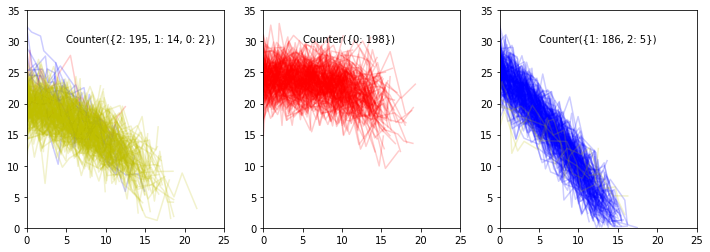

In [ ]:
mu_ = mu.detach().cpu().numpy()
plt.figure(figsize=(12,4))

for g in range(3):
    ids = np.array(list(range(0,len(data_train))))
    ids = ids[labels==g]
    plt.subplot(1, 3, g+1)
    c = 0
    for i in ids:
        if labels[i] != g:
            continue
        x = np.array(data_train[i][0])
        y = np.array(data_train[i][1])
        plt.plot(x,y,'-', alpha=0.2, color=cmap[groups[i]])
        c += 1
    c=Counter(groups[labels==g])
    plt.text(5,30,repr(c))
    plt.xlim(0,25)
    plt.ylim(0,35)

## Discussion

Here we show some potnetial usage of CNP for clustring longitudinal data. The CNP is used to convert the time courses with irregular time points to a latent space representation or a set of mean curves with regular time point such that we can apply conventional clustering techniques. Ideally, we should use CNP as a discriminator for computing the "distance" between two curves for clustering. We can also use the likelihood model generated CNP to better infer cluster membership. 

-- Jason Chin, Oct. 7 2018